# Guided Project: Detect Pneumonia Using X-Ray Images with CNNs and Transfer Learning

### Lu Yang
### 07-29-2023

Solution notebook can be referenced [here](https://github.com/dataquestio/solutions/blob/master/Mission784Solutions.ipynb).

## Introduction

According to the [World Health Organization](https://www.who.int/health-topics/pneumonia#tab=tab_1), pneumonia killed more than 808,000 children under the age of five in 2017. An accurate and timely diagnosis of the disease could be the difference in saving many lives.

How can we put our knowledge of CNNs and transfer learning to good use here?

In this guided project, we'll take on the role of a Deep Learning Engineer for an R&D company that focuses on developing cutting edge technologies to assist hospitals in diagnosing patients, particularly children. Thanks to researchers from the University of California, San Diego, the company has access to a dataset containing `5856` chest X-ray images from children, split between a training dataset and a test dataset. Each image has a label that specifies if the X-ray corresponds to a patient with pneumonia or one without it.

We're tasked with building a deep learning model trained on these images that can accurately classify whether an X-ray indicates signs of pneumonia.

![](https://s3.amazonaws.com/dq-content/784/1.1-m784.png)

### Loading Data

The data for this project is available for download [here](https://dsserver-prod-resources-1.s3.amazonaws.com/cnn/xray_dataset.tar.gz) as a compressed `tar.gz` file, and has the following directory structure when uncompressed:

```
chest_xray
├── test
│   ├── NORMAL
│   └── PNEUMONIA
└── train
    ├── NORMAL
    └── PNEUMONIA
```

Since there's no separate validation dataset available to us, we'll create a validation dataset from the training dataset.

In [1]:
import tarfile

def extract_tar_gz(file_path, output_path):
    with tarfile.open(file_path, mode='r:gz') as tar:
        tar.extractall(output_path)

In [2]:
# extract_tar_gz('./xray_dataset.tar.gz', './')

In [3]:
import tensorflow as tf
from tensorflow import keras
from keras.utils import image_dataset_from_directory

keras.utils.set_random_seed(123)

In [4]:
## create train & validation set using an 80/20 split

train_set = image_dataset_from_directory(
    directory='./chest_xray/train/', 
    labels='inferred', 
    label_mode='int', 
    batch_size=32,
    image_size=(256,256),
    seed=123,
    validation_split=0.2,
    subset='training'
)

validation_set = image_dataset_from_directory(
    directory='./chest_xray/train/', 
    labels='inferred', 
    label_mode='int', 
    batch_size=32,
    image_size=(256,256),
    seed=123,
    validation_split=0.2,
    subset='validation'
)

Found 5232 files belonging to 2 classes.
Using 4186 files for training.
Found 5232 files belonging to 2 classes.
Using 1046 files for validation.


In [5]:
## create test set

test_set = image_dataset_from_directory(
    directory='./chest_xray/test/', 
    labels='inferred', 
    label_mode='int', 
    batch_size=32,
    image_size=(256,256)
)

Found 624 files belonging to 2 classes.


Images are now rescaled by `1/255` to help with visualization using `matplotlib`.

In [6]:
from keras.layers import Rescaling

rescaling_layer = Rescaling(1/255.0)

In [7]:
train_rescaled = train_set.map(lambda imgs, labels: (rescaling_layer(imgs), labels))
validation_rescaled = validation_set.map(lambda imgs, labels: (rescaling_layer(imgs), labels))
test_rescaled = test_set.map(lambda imgs, labels: (rescaling_layer(imgs), labels))

##  Data Exploration

Next, let's explore our training and test sets by displaying some of the images and their associated labels. This will help us get an idea of what kind of model we should start with, and what data augmentation approaches could benefit the model.

Note that matplotlib expects the pixel values of the image arrays to be in the range of `[0, 1]`. If the image pixels are not in that range, we can ensure they are by dividing the image array by `255.0`.

In [8]:
train_set.class_names

['NORMAL', 'PNEUMONIA']

In [9]:
import matplotlib.pyplot as plt

In [10]:
## print shape & label for the 1st example in the 1st batch

for imgs, labels in train_rescaled.take(1):

    imgs = imgs.numpy()
    labels = labels.numpy()

    print(f'Image shape: {imgs[0].shape}')
    print(f'Label: {labels[0]}')

Image shape: (256, 256, 3)
Label: 1


(-0.5, 255.5, 255.5, -0.5)

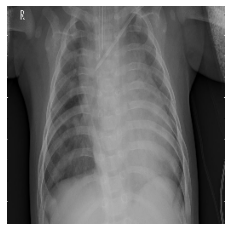

In [11]:
## Show the example image

plt.imshow(imgs[0])
plt.axis('off')

Let's see a few more examples from the first batch.

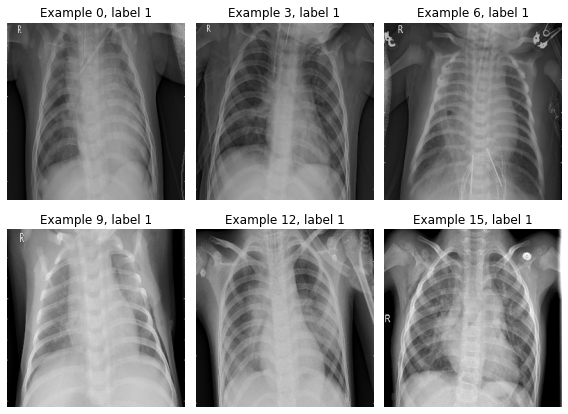

In [12]:
idx_list = [0,3,6,9,12,15]

plt.figure(figsize=(8,6))

for i, idx in enumerate(idx_list, 1):

    plt.subplot(2,3,i)
    plt.imshow(imgs[idx])
    plt.title(f'Example {idx}, label {labels[idx]}')
    plt.axis('off')

plt.tight_layout()

## First Model: Simple CNN I

One interesting observation we can make from our data exploration is that our images have `3` channels, even though they look like greyscale images. When creating our model, we'll have to make sure the dimensions of the input layer match with that of the images.

There's a lot of experimentation involved when it comes to building any deep learning model. It's advisable to start with a small model and train it for a few epochs to gauge how the model performs on the dataset.

After that, we can experiment by adding more layers to the model, tuning any hyperparameters, and re-training the model for a reasonable number of epochs till we notice any overfitting. If we do notice any overfitting, we can then add regularization or choose to tune hyperparameters further to try to improve the model's performance.

In this project we'll build multiple models, then evaluate those models on the test set at the end. So it's better to have unique variable names for each of those models.

In [13]:
from keras import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense
from keras.losses import BinaryCrossentropy
from keras.optimizers import Adam

In [14]:
cnn_model = Sequential()
cnn_model.add(Conv2D(filters=16, 
                     kernel_size=(3,3),
                     strides=2, 
                     padding='same',
                     activation='relu',
                     input_shape = (256,256,3)))
cnn_model.add(MaxPool2D(pool_size=(2,2),
                        strides=2))
cnn_model.add(Flatten())
cnn_model.add(Dense(8, activation='relu'))
cnn_model.add(Dense(1))

cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 16)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 65536)             0         
                                                                 
 dense (Dense)               (None, 8)                 524296    
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 524,753
Trainable params: 524,753
Non-trainable params: 0
__________________________________________________

In [15]:
opt = Adam(learning_rate=0.01)
loss = BinaryCrossentropy(from_logits=True)

cnn_model.compile(optimizer=opt, loss=loss, metrics=['accuracy'])

In [16]:
cnn_history = cnn_model.fit(train_rescaled, epochs=5, validation_data=validation_rescaled)

Epoch 1/5
131/131 [==============================] - 8s 43ms/step - loss: 0.9618 - accuracy: 0.7642 - val_loss: 0.1882 - val_accuracy: 0.9283
Epoch 2/5
131/131 [==============================] - 6s 47ms/step - loss: 0.2186 - accuracy: 0.9090 - val_loss: 0.2284 - val_accuracy: 0.9082
Epoch 3/5
131/131 [==============================] - 6s 47ms/step - loss: 0.1409 - accuracy: 0.9467 - val_loss: 0.2390 - val_accuracy: 0.9120
Epoch 4/5
131/131 [==============================] - 6s 47ms/step - loss: 0.1607 - accuracy: 0.9515 - val_loss: 0.3218 - val_accuracy: 0.8690
Epoch 5/5
131/131 [==============================] - 6s 47ms/step - loss: 0.2077 - accuracy: 0.9087 - val_loss: 0.2942 - val_accuracy: 0.8690


In [17]:
## Helper fn to plot training and validation loss & accuracy

def plot_training_history(history):

    plt.figure(figsize = (10,5))

    plt.subplot(1,2,1)
    plt.plot(history.epoch, history.history['loss'], label = 'Train')
    plt.plot(history.epoch, history.history['val_loss'], label = 'Validation')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Training and validation loss in {len(history.epoch)} epochs')

    plt.subplot(1,2,2)
    plt.plot(history.epoch, history.history['accuracy'], label = 'Train')
    plt.plot(history.epoch, history.history['val_accuracy'], label = 'Validation')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'Training and validation accuracy in {len(history.epoch)} epochs')

    plt.tight_layout()

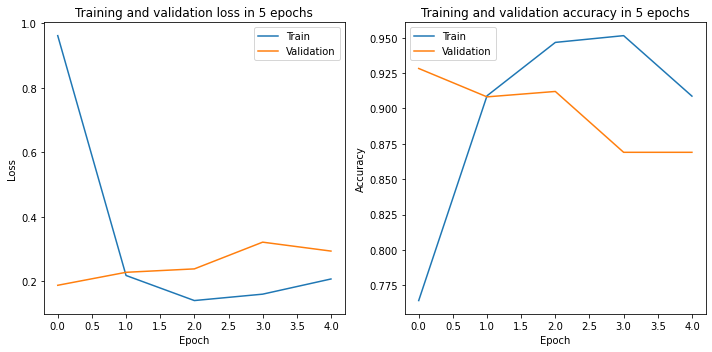

In [18]:
plot_training_history(cnn_history)

In [19]:
train_set_all = image_dataset_from_directory(
    directory='./chest_xray/train/', 
    labels='inferred', 
    label_mode='int', 
    batch_size=None,
    image_size=(256,256)
)

Found 5232 files belonging to 2 classes.


In [20]:
import numpy as np

y = [labels.numpy() for imgs, labels in train_set_all]
print(len(y), np.mean(y))

5232 0.7421636085626911


It appears that the training set overall has `~74%` images labelled as `1`. Thus, an accuracy of `95%` is considered effective for prediction even just with a simple CNN model. Minor overfitting may have occurred since the validation loss seems to stop decreasing.

## First Model: Simple CNN II

Even with a basic model like the one we just built, we may see signs of overfitting if our training and validation accuracies are really high, particularly after just `5` epochs of training time. This can happen because the model could be learning to classify based on features that might not be that relevant to the infection.

For example, let's consider the `beans` dataset from the lessons. The leaves might have had certain colored spots on them that could tell us that they are diseased. However, what if the dataset had a lot of yellow-colored leaves that were labeled as healthy and a lot of green-colored leaves that were labeled as diseased? Could the model have learned to associate the color of the leaves to the disease? It's possible the model could learn to classify the leaves based on an irrelevant feature (the color of the leaves) instead of the relevant one (the color of the spots on those leaves). The data collection process might've had some bias that the model was able to exploit, even if we didn't know about it.

Something similar could very well be happening with our chest X-rays. Very high training and validation accuracies could imply the model is overfitting as a result.

We'll use some form of regularization and data augmentation in the model in an attempt to reduce any potential overfitting and to allow the model to learn more relevant features as well.

We can also experiment with the architecture to try to improve its performance. We can add layers, tune hyperparameters, and, if there's any overfitting, we can add regularization and image augmentation layers. We can also change the dimensions of our dataset images either by simply modifying the corresponding parameter when we load in the datasets or by adding a resizing layer.

There's no end to the experimentation, so the goal is to aim for training and validation accuracies higher than `85%` after training the model for up to `10` epochs. Please note that this is not a strict requirement. We also recommend that you iteratively modify the architecture and try to observe how it impacts the performance.

This is also where our knowledge of the dataset from our data exploration could be useful. Not every data augmentation technique is likely to improve our model's performance. For example, vertically flipping an X-ray image is less likely to benefit our model since it won't be representative of our dataset, especially not any test or unseen data.

In [21]:
## Try some augmentation layer: Rotation (less relevant for X-ray images) and Zoom (more relevant for X-ray images)
## Try some regularization approaches: Dropout and L2 Regularization
## Try the EarlyStopping callback

from keras.layers import RandomRotation, RandomZoom, Dropout
from keras.regularizers import L2
from keras.callbacks import EarlyStopping

### Augmentation via random rotation

In [22]:
cnn_model_rotation = Sequential()
cnn_model_rotation.add(RandomRotation(factor=0.1,
                                         seed=123,
                                         input_shape=(256,256,3)))
cnn_model_rotation.add(Conv2D(filters=32, 
                     kernel_size=(3,3),
                     strides=2, 
                     padding='same',
                     activation='relu',
                     kernel_regularizer=L2(0.0005)
                     ))

cnn_model_rotation.add(MaxPool2D(pool_size=(2,2),
                        strides=2))
cnn_model_rotation.add(Flatten())
cnn_model_rotation.add(Dense(128, activation='relu', 
                                kernel_regularizer=L2(0.0001)
                                ))
cnn_model_rotation.add(Dropout(0.1))
cnn_model_rotation.add(Dense(16, activation='relu'))
cnn_model_rotation.add(Dense(1))

cnn_model_rotation.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_rotation (RandomRota  (None, 256, 256, 3)      0         
 tion)                                                           
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 131072)            0         
                                                                 
 dense_2 (Dense)             (None, 128)               16777344  
                                                                 
 dropout (Dropout)           (None, 128)              

In [23]:
opt = Adam(learning_rate=0.01)
loss = BinaryCrossentropy(from_logits=True)
cnn_model_rotation.compile(optimizer=opt, loss=loss, metrics=['accuracy'])

callbacks = EarlyStopping(monitor='val_loss', mode='min', patience=3)
cnn_rotation_history = cnn_model_rotation.fit(
    train_rescaled, 
    epochs=20, 
    validation_data=validation_rescaled,
    callbacks=callbacks)

Epoch 1/20
131/131 [==============================] - 18s 119ms/step - loss: 2.6001 - accuracy: 0.6722 - val_loss: 1.2526 - val_accuracy: 0.7744
Epoch 2/20
131/131 [==============================] - 16s 117ms/step - loss: 1.0496 - accuracy: 0.7341 - val_loss: 0.8455 - val_accuracy: 0.7744
Epoch 3/20
131/131 [==============================] - 16s 119ms/step - loss: 0.7949 - accuracy: 0.7341 - val_loss: 0.6905 - val_accuracy: 0.7744
Epoch 4/20
131/131 [==============================] - 16s 119ms/step - loss: 0.6911 - accuracy: 0.7341 - val_loss: 0.6218 - val_accuracy: 0.7744
Epoch 5/20
131/131 [==============================] - 15s 115ms/step - loss: 0.6410 - accuracy: 0.7341 - val_loss: 0.5867 - val_accuracy: 0.7744
Epoch 6/20
131/131 [==============================] - 16s 117ms/step - loss: 0.6147 - accuracy: 0.7341 - val_loss: 0.5702 - val_accuracy: 0.7744
Epoch 7/20
131/131 [==============================] - 16s 117ms/step - loss: 0.6001 - accuracy: 0.7341 - val_loss: 0.5584 - val_ac

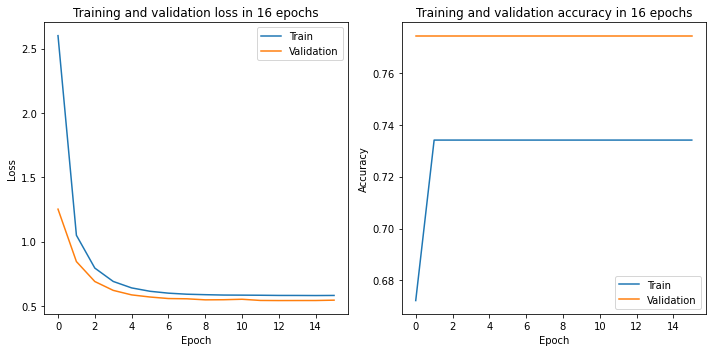

In [24]:
plot_training_history(cnn_rotation_history)

### Augmentation via random zoom

In [25]:
cnn_model_zoom = Sequential()
cnn_model_zoom.add(RandomZoom(height_factor=0.1,
                              width_factor=0.1,
                              seed=123,
                              input_shape=(256,256,3)))
cnn_model_zoom.add(Conv2D(filters=32, 
                     kernel_size=(3,3),
                     strides=2, 
                     padding='same',
                     activation='relu',
                     kernel_regularizer=L2(0.0005)
                     ))

cnn_model_zoom.add(MaxPool2D(pool_size=(2,2),
                        strides=2))
cnn_model_zoom.add(Flatten())
cnn_model_zoom.add(Dense(128, activation='relu', 
                                kernel_regularizer=L2(0.0001)
                                ))
cnn_model_zoom.add(Dropout(0.1))
cnn_model_zoom.add(Dense(16, activation='relu'))
cnn_model_zoom.add(Dense(1))

cnn_model_zoom.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_zoom (RandomZoom)    (None, 256, 256, 3)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 131072)            0         
                                                                 
 dense_5 (Dense)             (None, 128)               16777344  
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                      

In [26]:
opt = Adam(learning_rate=0.01)
loss = BinaryCrossentropy(from_logits=True)
cnn_model_zoom.compile(optimizer=opt, loss=loss, metrics=['accuracy'])

callbacks = EarlyStopping(monitor='val_loss', mode='min', patience=3)
cnn_zoom_history = cnn_model_zoom.fit(
    train_rescaled, 
    epochs=20, 
    validation_data=validation_rescaled,
    callbacks=callbacks)

Epoch 1/20
131/131 [==============================] - 24s 172ms/step - loss: 1.5340 - accuracy: 0.4790 - val_loss: 0.9270 - val_accuracy: 0.7744
Epoch 2/20
131/131 [==============================] - 23s 170ms/step - loss: 0.7969 - accuracy: 0.7341 - val_loss: 0.6562 - val_accuracy: 0.7744
Epoch 3/20
131/131 [==============================] - 23s 172ms/step - loss: 0.6758 - accuracy: 0.7301 - val_loss: 0.6306 - val_accuracy: 0.7744
Epoch 4/20
131/131 [==============================] - 22s 168ms/step - loss: 0.6598 - accuracy: 0.7341 - val_loss: 0.6198 - val_accuracy: 0.7744
Epoch 5/20
131/131 [==============================] - 23s 172ms/step - loss: 0.6291 - accuracy: 0.7341 - val_loss: 0.5520 - val_accuracy: 0.7744
Epoch 6/20
131/131 [==============================] - 24s 178ms/step - loss: 0.5862 - accuracy: 0.7341 - val_loss: 0.5435 - val_accuracy: 0.7744
Epoch 7/20
131/131 [==============================] - 23s 175ms/step - loss: 0.5821 - accuracy: 0.7341 - val_loss: 0.5419 - val_ac

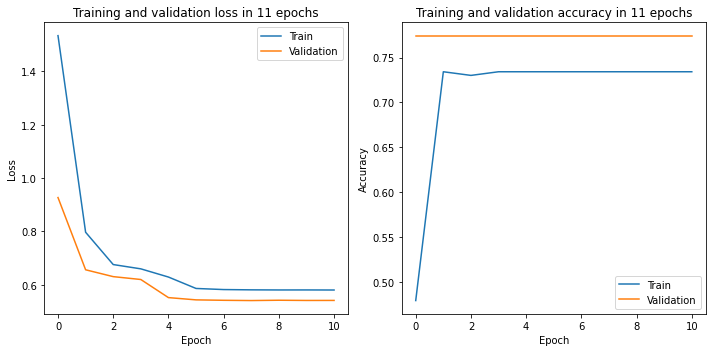

In [27]:
plot_training_history(cnn_zoom_history)

## Second Model: Transfer Learning

We'll build our second model using transfer learning. Pre-trained models that were trained on the ImageNet dataset might not be the best choice for transfer learning here. ImageNet unfortunately doesn't contain classes that are a reasonable match for X-rays.

However, that doesn't imply that the pre-trained weights can't be useful feature extractors. Ideally, we'd want to use a model trained on a similar dataset, but finding such a model can be a difficult task. We'll stick to what's available to us for now.

TensorFlow offers several [pre-trained models](https://www.tensorflow.org/api_docs/python/tf/keras/applications) we could choose from instead of relying on a ResNet model. We can pick one at random and try it out.

The only caveat is that we wouldn't know how many layers to unfreeze when we fine-tune our model, since we would have to know the pre-trained model's architecture. Knowing the architecture is not strictly necessary, though. We could either unfreeze all the layers, or we could unfreeze the last 
N
 layers without knowing what those 
N
 layers correspond to in the architecture.

While you're encouraged to experiment, we strongly recommend you use one of the ResNet-based pre-trained models for this project:

* `ResNet50`
* `ResNet v2`

    * This module contains different functions for a newer version of different ResNet architectures such as [`ResNet50`](https://www.tensorflow.org/api_docs/python/tf/keras/applications/resnet_v2/ResNet50V2) and [`ResNet101`](https://www.tensorflow.org/api_docs/python/tf/keras/applications/resnet_v2/ResNet101V2).

As a reminder, we also need to make sure that ***the input to the model is preprocessed in the same way as the inputs to the pre-trained model***.

###  Transfer learning using `Resnet50`

In [28]:
from keras.applications import resnet
from keras import Input, Model
from keras.layers import GlobalAveragePooling2D

In [29]:
resnet50 = resnet.ResNet50(include_top=False)
## freeze all layers
resnet50.trainable = False

In [30]:
def TL_resnet50():

    inputs = Input(shape = (256,256,3))
    x = resnet.preprocess_input(inputs)
    x = resnet50(x)
    x = GlobalAveragePooling2D()(x)
    x = Dense(32)(x)
    outputs= Dense(1)(x)

    return Model(inputs = inputs, outputs = outputs)

In [31]:
resnet_50 = TL_resnet50()
resnet_50.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 256, 256, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 256, 256, 3)      0         
                                                                 
 resnet50 (Functional)       (None, None, None, 2048)  23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_8 (Dense)             (None, 32)                65568 

In [32]:
opt = Adam(learning_rate=0.0003)
loss = BinaryCrossentropy(from_logits=True)
resnet_50.compile(optimizer=opt, loss=loss, metrics=['accuracy'])

callbacks = EarlyStopping(monitor='val_loss', mode='min', patience=3)
resnet_50_history = resnet_50.fit(
    train_set, ## no additional preprocessing needed
    epochs=10, 
    validation_data=validation_set,
    callbacks=callbacks) 

Epoch 1/10
131/131 [==============================] - 25s 171ms/step - loss: 0.1608 - accuracy: 0.9255 - val_loss: 0.0909 - val_accuracy: 0.9732
Epoch 2/10
131/131 [==============================] - 21s 161ms/step - loss: 0.0863 - accuracy: 0.9668 - val_loss: 0.0613 - val_accuracy: 0.9713
Epoch 3/10
131/131 [==============================] - 22s 163ms/step - loss: 0.0758 - accuracy: 0.9706 - val_loss: 0.0696 - val_accuracy: 0.9637
Epoch 4/10
131/131 [==============================] - 22s 164ms/step - loss: 0.0551 - accuracy: 0.9802 - val_loss: 0.0419 - val_accuracy: 0.9818
Epoch 5/10
131/131 [==============================] - 22s 165ms/step - loss: 0.0499 - accuracy: 0.9811 - val_loss: 0.0401 - val_accuracy: 0.9828
Epoch 6/10
131/131 [==============================] - 22s 169ms/step - loss: 0.0495 - accuracy: 0.9799 - val_loss: 0.0386 - val_accuracy: 0.9857
Epoch 7/10
131/131 [==============================] - 22s 166ms/step - loss: 0.0363 - accuracy: 0.9878 - val_loss: 0.0330 - val_ac

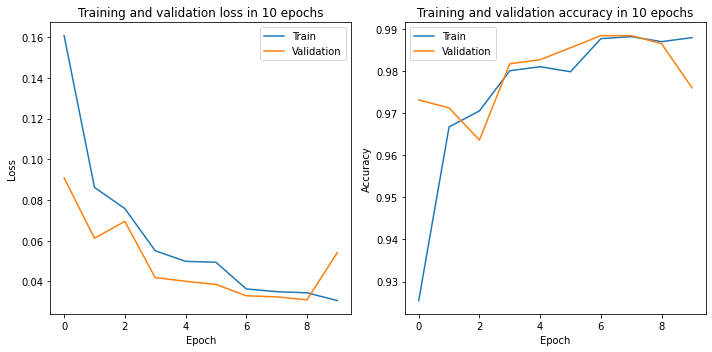

In [33]:
plot_training_history(resnet_50_history)

### Transfer learning using `Resnet50V2`

In [34]:
from keras.applications import resnet_v2

In [35]:
resnet50v2 = resnet_v2.ResNet50V2(include_top=False)
## freeze all layers
resnet50v2.trainable = False

In [36]:
def TL_resnet50v2():

    inputs = Input(shape = (256,256,3))
    x = resnet_v2.preprocess_input(inputs)
    x = resnet50v2(x)
    x = GlobalAveragePooling2D()(x)
    x = Dense(32)(x)
    outputs= Dense(1)(x)

    return Model(inputs = inputs, outputs = outputs)

In [37]:
resnet_50_v2 = TL_resnet50v2()
resnet_50_v2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 256, 256, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 256, 256, 3)      0         
 a)                                                              
                                                                 
 resnet50v2 (Functional)     (None, None, None, 2048)  23564800  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                           

In [38]:
opt = Adam(learning_rate=0.0003)
loss = BinaryCrossentropy(from_logits=True)
resnet_50_v2.compile(optimizer=opt, loss=loss, metrics=['accuracy'])

callbacks = EarlyStopping(monitor='val_loss', mode='min', patience=3)
resnet_50_v2_history = resnet_50_v2.fit(
    train_set, ## no additional preprocessing needed
    epochs=10, 
    validation_data=validation_set,
    callbacks=callbacks) 

Epoch 1/10
131/131 [==============================] - 22s 153ms/step - loss: 0.3495 - accuracy: 0.8595 - val_loss: 0.1385 - val_accuracy: 0.9522
Epoch 2/10
131/131 [==============================] - 19s 146ms/step - loss: 0.1224 - accuracy: 0.9546 - val_loss: 0.1065 - val_accuracy: 0.9646
Epoch 3/10
131/131 [==============================] - 19s 147ms/step - loss: 0.0950 - accuracy: 0.9644 - val_loss: 0.0910 - val_accuracy: 0.9685
Epoch 4/10
131/131 [==============================] - 19s 147ms/step - loss: 0.0780 - accuracy: 0.9732 - val_loss: 0.0818 - val_accuracy: 0.9704
Epoch 5/10
131/131 [==============================] - 20s 151ms/step - loss: 0.0652 - accuracy: 0.9773 - val_loss: 0.0791 - val_accuracy: 0.9685
Epoch 6/10
131/131 [==============================] - 20s 151ms/step - loss: 0.0585 - accuracy: 0.9787 - val_loss: 0.0741 - val_accuracy: 0.9780
Epoch 7/10
131/131 [==============================] - 20s 147ms/step - loss: 0.0517 - accuracy: 0.9828 - val_loss: 0.0712 - val_ac

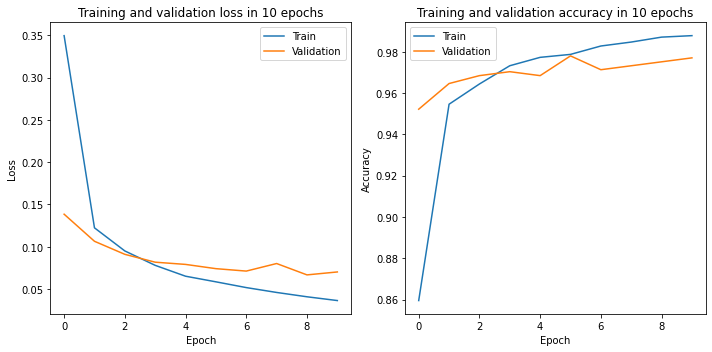

In [39]:
plot_training_history(resnet_50_v2_history)

It appears that the `ResNet50V2` performs a bit more reliably, let’s try unfreeze the top `10` layers and allow them to be trained.
### Transfer learning using `Resnet50V2` with 10 layers unfrozen

In [40]:
resnet50v2_10L = resnet_v2.ResNet50V2(include_top=False)

## unfreeze all layers first
resnet50v2_10L.trainable = True

## freeze all other layers except last 10
for layer in resnet50v2_10L.layers[:-10]:
    layer.trainable = False

In [41]:
def TL_resnet50v2_10L():

    inputs = Input(shape = (256,256,3))
    x = resnet_v2.preprocess_input(inputs)
    x = resnet50v2_10L(x)
    x = GlobalAveragePooling2D()(x)
    x = Dense(32)(x)
    outputs= Dense(1)(x)

    return Model(inputs = inputs, outputs = outputs)

In [42]:
resnet_50_v2_10L = TL_resnet50v2_10L()
resnet_50_v2_10L.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 256, 256, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 256, 256, 3)      0         
 bda)                                                            
                                                                 
 resnet50v2 (Functional)     (None, None, None, 2048)  23564800  
                                                                 
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                           

In [43]:
opt = Adam(learning_rate=0.0003)
loss = BinaryCrossentropy(from_logits=True)
resnet_50_v2_10L.compile(optimizer=opt, loss=loss, metrics=['accuracy'])

callbacks = EarlyStopping(monitor='val_loss', mode='min', patience=3)
resnet_50_v2_10L_history = resnet_50_v2_10L.fit(
    train_set, ## no additional preprocessing needed
    epochs=10, 
    validation_data=validation_set,
    callbacks=callbacks) 

Epoch 1/10
131/131 [==============================] - 23s 156ms/step - loss: 0.1069 - accuracy: 0.9603 - val_loss: 0.0699 - val_accuracy: 0.9751
Epoch 2/10
131/131 [==============================] - 19s 143ms/step - loss: 0.0217 - accuracy: 0.9928 - val_loss: 0.0589 - val_accuracy: 0.9799
Epoch 3/10
131/131 [==============================] - 19s 142ms/step - loss: 0.0126 - accuracy: 0.9962 - val_loss: 0.0539 - val_accuracy: 0.9837
Epoch 4/10
131/131 [==============================] - 19s 146ms/step - loss: 0.0041 - accuracy: 0.9986 - val_loss: 0.0649 - val_accuracy: 0.9866
Epoch 5/10
131/131 [==============================] - 21s 156ms/step - loss: 0.0046 - accuracy: 0.9981 - val_loss: 0.0465 - val_accuracy: 0.9847
Epoch 6/10
131/131 [==============================] - 21s 158ms/step - loss: 0.0033 - accuracy: 0.9990 - val_loss: 0.0577 - val_accuracy: 0.9761
Epoch 7/10
131/131 [==============================] - 21s 158ms/step - loss: 0.0046 - accuracy: 0.9983 - val_loss: 0.0879 - val_ac

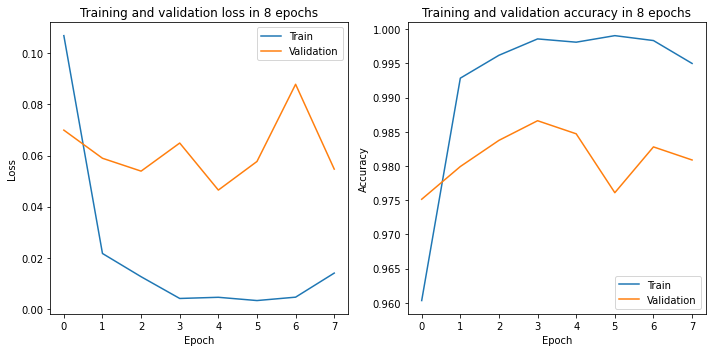

In [44]:
plot_training_history(resnet_50_v2_10L_history)

## Evaluating on the Test Set

In [45]:
def evaluate_test_data(model, test_data):
    test_loss, test_acc = model.evaluate(test_data)
    print()
    print(f'Test loss {test_loss :.4f}\nTest accuracy {test_acc :.4f}\n')

In [46]:
print('Simple CNN')
evaluate_test_data(cnn_model, test_rescaled)
print('Simple CNN with augmentation via rotation and regularization')
evaluate_test_data(cnn_model_rotation, test_rescaled)
print('Simple CNN with augmentation via zoom-in and regularization')
evaluate_test_data(cnn_model_zoom, test_rescaled)

Simple CNN
20/20 [==============================] - 1s 27ms/step - loss: 0.9545 - accuracy: 0.8157

Test loss 0.9545
Test accuracy 0.8157

Simple CNN with augmentation via rotation and regularization
20/20 [==============================] - 1s 29ms/step - loss: 0.6805 - accuracy: 0.6250

Test loss 0.6805
Test accuracy 0.6250

Simple CNN with augmentation via zoom-in and regularization
20/20 [==============================] - 1s 27ms/step - loss: 0.6858 - accuracy: 0.6250

Test loss 0.6858
Test accuracy 0.6250



In [47]:
print('ResNet50')
evaluate_test_data(resnet_50, test_set)
print('ResNet50V2')
evaluate_test_data(resnet_50_v2, test_set)
print('ResNet50V2 with 10 layers unfrozen')
evaluate_test_data(resnet_50_v2_10L, test_set)

ResNet50
20/20 [==============================] - 3s 128ms/step - loss: 0.5238 - accuracy: 0.8494

Test loss 0.5238
Test accuracy 0.8494

ResNet50V2
20/20 [==============================] - 3s 116ms/step - loss: 0.8168 - accuracy: 0.7917

Test loss 0.8168
Test accuracy 0.7917

ResNet50V2 with 10 layers unfrozen
20/20 [==============================] - 3s 113ms/step - loss: 1.1831 - accuracy: 0.8558

Test loss 1.1831
Test accuracy 0.8558

